In [13]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [14]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras

# 각종 변수 선언
csv_path = '../data/Regression_data.csv'
save_path = '../../../../../Git_Blog/assets/images/aib/GPTeachersDay/'
save_mode = 0

In [15]:
def load_data(csv_path, TRAIN_RATIO=0.8):
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # # 전체무게가 음수인 경우 삭제
    # minus_list = df['Whole weight'] - (df['Shucked weight'] + df['Viscera weight'] + df['Shell weight'])
    # minus_list = minus_list[minus_list < 0]
    # df.drop(minus_list.index, axis=0, inplace=True)
    
    # 껍질의 넓이 ( a * b * π)
    df['Area'] = 0.5 * df['Length'] * 0.5 * df['Diameter'] * np.pi
        
    # 껍질의 둘레 (근사) ( 2π*(0.5 * √(a^2 + b^2)))
    df['Perimeter'] = np.pi * np.sqrt(0.5 * ((df['Length'] ** 2) + (df['Diameter'] ** 2)))
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings'].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # MinMaxScaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    return df, X, y, X_train, X_test, y_train, y_test
    
df, X, y, X_train, X_test, y_train, y_test = load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3341, 12) (836, 12) (3341,) (836,)


In [16]:
X_train.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Area,Perimeter,Sex_F,Sex_I,Sex_M
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.586063,0.566583,0.123549,0.295028,0.238986,0.236861,0.234517,0.413360,0.578706,0.314576,0.317869,0.367555
std,0.169907,0.176811,0.037735,0.176108,0.148858,0.144044,0.137815,0.180950,0.171961,0.464416,0.465718,0.482211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.482270,0.455357,0.101770,0.156233,0.122854,0.120474,0.126747,0.281427,0.474190,0.000000,0.000000,0.000000
50%,0.617021,0.598214,0.123894,0.285585,0.223157,0.225148,0.231537,0.422430,0.606366,0.000000,0.000000,0.000000
75%,0.716312,0.696429,0.146018,0.410608,0.333894,0.331797,0.321357,0.548812,0.707719,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\leeyeonjun85\AppData\Local\Temp\ipykernel_3996\3429257515.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


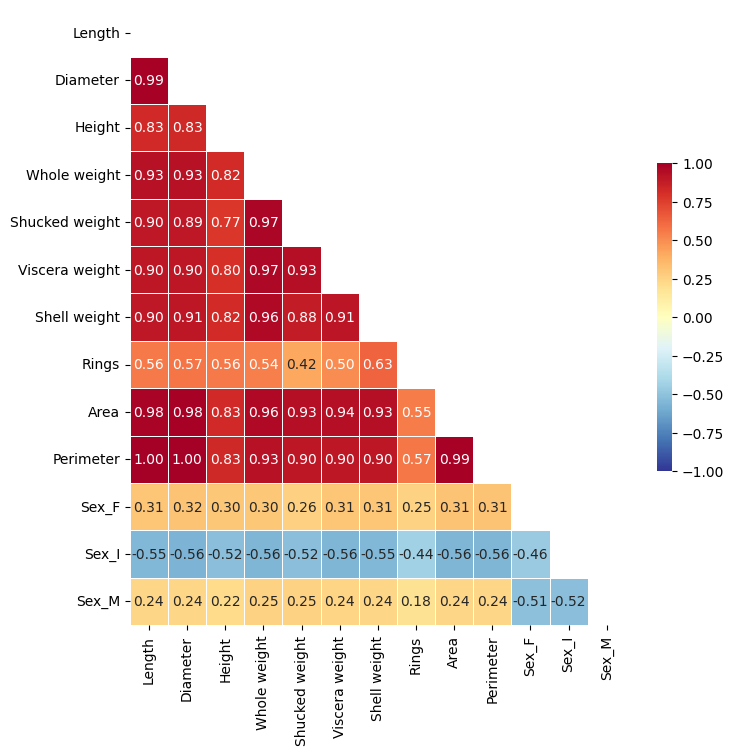

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            cmap="RdYlBu_r",
            annot=True,
            mask=mask,
            fmt='.2f',
            linewidths=.5,
            vmin = -1, vmax = 1,
            cbar_kws={"shrink": .5})

plt.show()

fig.savefig('model1_heatmap.png', dpi=80, bbox_inches='tight')

In [18]:
def get_model(shape, node_n=12, dout=0.1):
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(node_n//2)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(node_n//4)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(node_n//8)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(node_n//16)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(node_n//8)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(node_n//4)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(node_n//2)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(node_n)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    dense10  = keras.layers.Dense(node_n//2)(dout9)
    norm10   = keras.layers.BatchNormalization()(dense10)
    relu10   = keras.layers.Activation('relu')(norm10)
    dout10   = keras.layers.Dropout(dout)(relu10)
    
    outputs = keras.layers.Dense(1)(dout10)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    return model

model = get_model(len(X_train.columns))
print(model.summary())
    

Model: "Abalone_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 12)           156         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 12)          48          ['dense_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_10 (Activation)     (None, 12)           0           ['batch_normalization

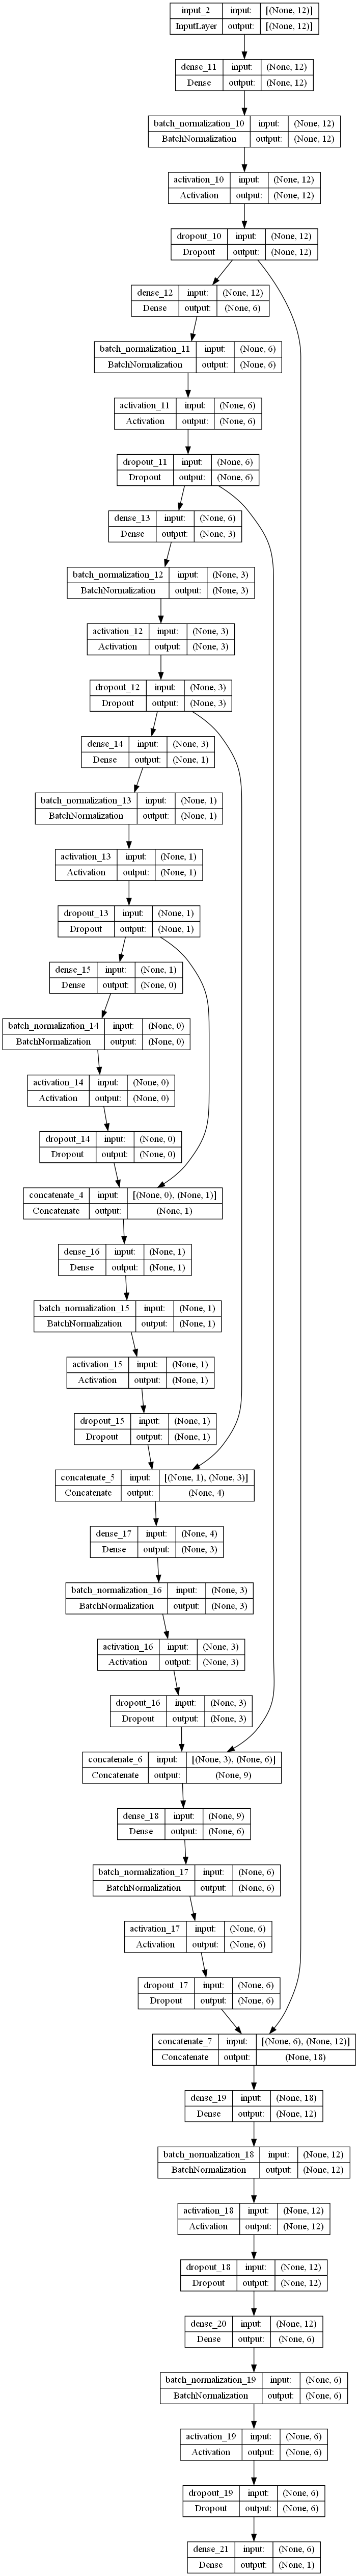

In [19]:
keras.utils.plot_model(model, show_shapes=True, to_file='model1_model.png')

In [20]:
class EvalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_states(self):
        self.correct.assign(0.)

class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

In [21]:
model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )

EPOCHS = 1000

# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                        , min_delta=0.000001
                                        , patience=EPOCHS//5)

# 모델 저장
checkpoint_path = 'model1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_accuracy'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 학습률 조정
lr_decay = keras.optimizers.schedules.CosineDecay(
                                        initial_learning_rate=0.001
                                        , decay_steps=EPOCHS
                                        , alpha=1e-12)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# 모델 학습
history = model.fit(X_train, y_train
                    , batch_size=1024
                    , validation_split = 0.2
                    , verbose=0
                    , epochs=EPOCHS
                    , callbacks=[earlystop, checkpoint, lr_scheduler, CustomCallback()]
                    )

Starting training


c:\Users\leeyeonjun85\.conda\envs\p310_1\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / 660 / 670 / 680 / 690 / 
700 / 710 / 720 / 730 / 740 / 750 / 760 / 770 / 780 / 790 / 
800 / 810 / 820 / 830 / 840 / 850 / 860 / 870 / 880 / 890 / 
900 / 910 / 920 / 930 / 940 / 950 / 960 / 970 / 980 / 990 / End training


In [22]:
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss : {loss:.3f}\nAccuracy  : {accuracy:.3f}')

22/27 [=======================>......] - ETA: 0s - loss: 5.2950 - accuracy: 0.8499

c:\Users\leeyeonjun85\.conda\envs\p310_1\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


27/27 [==============================] - 0s 8ms/step - loss: 5.3877 - accuracy: 0.9174
Test Loss : 5.388
Accuracy  : 0.917


In [23]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)

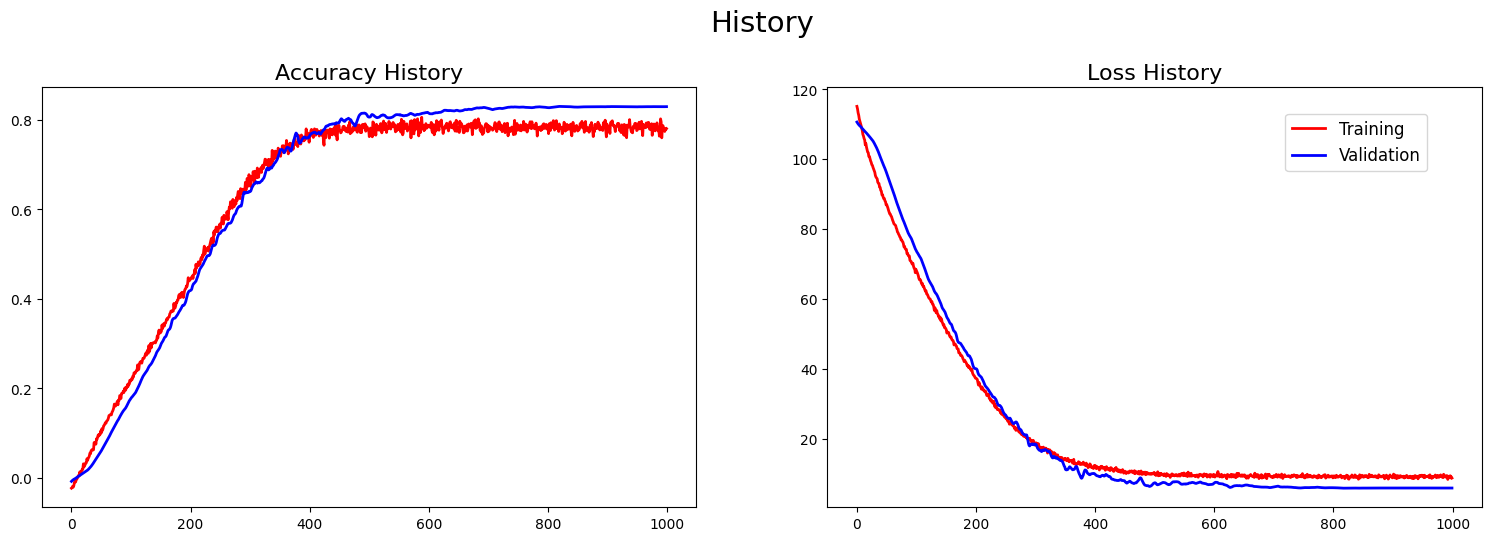

In [24]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_history.png', dpi=80, bbox_inches='tight')